In [11]:
using AxUtil, Random, ProgressMeter, ArgCheck
using Sobol, ForwardDiff, Optim
using PyPlot, AxPlot

In [5]:
function disperse_obj(X; bw=1/25)
    @argcheck size(X,2) == 2
    n = size(X,1)
    bdp = 8
    U = hcat(vcat(range(0,stop=1,length=bdp), ones(bdp-2), range(1,stop=0,length=bdp), zeros(bdp-2)), 
        vcat(zeros(bdp-2+1), range(0,stop=1,length=bdp), ones(bdp-2), range(1,stop=0,length=bdp)[1:bdp-1]))
#     U = Matrix([0 0.5 1 1 1 0.5 0 0; 0 0 0 0.5 1 1 1 0.5]')
#     U = Matrix([0 1 1 0; 0 0 1 1.]')
    out = sum(exp.(-1/bw*AxUtil.Math.sq_diff_matrix(X, X))) + sum(exp.(-5/bw*AxUtil.Math.sq_diff_matrix(X, U)))
    return out / n
end

disperse_obj (generic function with 1 method)

In [6]:
d = 5
res = optimize(disperse_obj, zeros(5,2), ones(5,2), AxUtil.Random.randomised_sobol(5, 2), Fminbox(LBFGS()); autodiff = :forward)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.1929300430149603,0.4429300430149603, ...]
 * Minimizer: [0.18541499421324462,0.6474813120952203, ...]
 * Minimum: 1.045939e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 1.64e-07 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 6.50e-14 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 5.61e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 236
 * Gradient Calls: 236

In [7]:
opt_x, opt_f = let opt_x = []; opt_f = zeros(20);
    @showprogress for d = 1:20
        nretry = 20
        best_res = nothing
        for nn = 1:nretry
            low, up = 0.02, 0.98
            x0 = AxUtil.Random.randomised_sobol(d, 2)
            x0 = min.(up-1e-2, max.(x0, low+1e-2))
            res = optimize(disperse_obj, ones(d,2)*low, ones(d,2)*up, x0, Fminbox(LBFGS()); autodiff = :forward)
            if nn == 1
                best_res = res
            else
                if res.minimum < best_res.minimum
                    best_res = res
                end
            end
        end
        push!(opt_x, best_res.minimizer)
        opt_f[d] = best_res.minimum
    end
    opt_x, opt_f
end
# scatter(best_res.minimizer[:,1], best_res.minimizer[:,2])
# gca()[:set_title](format("objective = {:.5f}", best_res.minimum))
# gca()[:set_xlim](0,1); gca()[:set_ylim](0,1)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


(Any[[0.5 0.5], [0.716749 0.283251; 0.283251 0.716749], [0.763437 0.744131; 0.5 0.245413; 0.236563 0.744131], [0.237653 0.237653; 0.762347 0.762347; 0.762347 0.237653; 0.237653 0.762347], [0.200999 0.200999; 0.200999 0.799001; … ; 0.799001 0.799001; 0.5 0.5], [0.818353 0.181647; 0.822964 0.788673; … ; 0.165412 0.575959; 0.424041 0.834588], [0.802064 0.845079; 0.832388 0.496392; … ; 0.824269 0.157393; 0.158783 0.377886], [0.84619 0.166058; 0.15381 0.833942; … ; 0.15381 0.166058; 0.5 0.826619], [0.5 0.5; 0.84138 0.15862; … ; 0.15862 0.15862; 0.844234 0.5], [0.863558 0.525352; 0.152064 0.152064; … ; 0.136442 0.474648; 0.152869 0.847131], [0.86513 0.860266; 0.67627 0.641769; … ; 0.131633 0.440945; 0.5 0.882031], [0.137607 0.364665; 0.412072 0.5; … ; 0.137607 0.635335; 0.864137 0.13228], [0.878997 0.36303; 0.172494 0.363893; … ; 0.829221 0.113233; 0.132214 0.61745], [0.105405 0.105405; 0.371617 0.87526; … ; 0.148318 0.371352; 0.371352 0.148318], [0.381783 0.618217; 0.871745 0.375766; … ; 0.

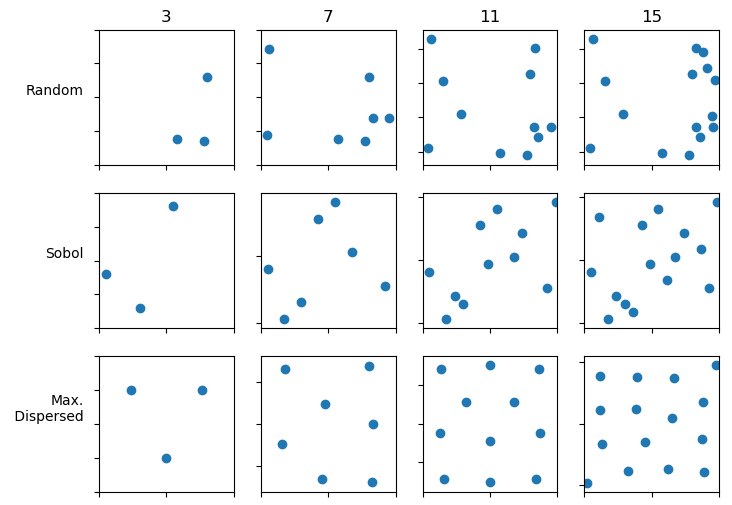

PyObject Text(83.75, 0.5, 'Max.\n Dispersed')

In [12]:
fig, axs = subplots(3, 4, figsize=(8,6))
for (i,pp) in enumerate([3,7,11,15])
    for j in 1:3
        Random.seed!(101010)
        X = j == 1 ? rand(2, pp)' : j == 2 ? AxUtil.Random.randomised_sobol(pp,2) : opt_x[pp]
        axs[j,i][:scatter](X[:,1], X[:,2])
#         axs[j,i][:set_title](format("{:.5f}", opt_f[pp]))
        axs[j,i][:set_xlim](0,1); axs[i][:set_ylim](0,1)
        axs[j,i][:set_xticklabels]([])
        axs[j,i][:set_yticklabels]([])
    end
    axs[1,i][:set_title](pp)
end
axs[1,1][:set_ylabel]("Random", rotation=0, horizontalalignment="right")
axs[2,1][:set_ylabel]("Sobol", rotation=0, horizontalalignment="right")
axs[3,1][:set_ylabel]("Max.\n Dispersed", rotation=0, horizontalalignment="right")

# savefig("compare_qmc.pdf")

In [ ]:
# BSON.bson("max_discr_seq.bson", opt_f=opt_f, opt_x=opt_x)